# Welcome to the Live Implied Volatility & VIX-like Interactive Dashboard !

This interactive dashboard provides a market-consistent view of implied volatility and volatility expectations extracted directly from live listed option prices.
By changing a single underlying ticker and re-running the notebook, the entire analysis updates automatically to reflect the current option market snapshot.

The objective is not option pricing, but volatility interpretation: understanding how the market prices risk across strikes and maturities at a given observation date.

## How to Use the Dashboard
Step 1 — Select the Underlying & Market Assumptions. In the Inputs Parameters section, the user only needs to:
- choose an underlying ticker (e.g. AAPL, NVDA, SPY),
- select a data-quality preset controlling option filtering,
- specify basic market assumptions (risk-free rate, dividend yield),
- define the target maturity for the VIX-like index (e.g. 30 days).

Once the ticker is set, the engine fetches live option chains, computes the spot price, and builds a clean snapshot of all tradable call and put contracts at the current market state. No manual data preparation or historical data loading is required.

## What Happens Next 

Each time the notebook is run, the following pipeline executes automatically:

**Live option prices → Implied volatilities → Smiles → Surface → VIX-like index**

*All outputs are generated from the same real-time market snapshot and remain internally consistent.*

## Dashboard Outputs
**Output 1 — Implied Volatility Table**

Observed option prices are inverted through the Black–Scholes model to recover implied volatilities for each contract. Illiquid or non-invertible quotes are automatically filtered out, resulting in a clean implied volatility table across strikes and maturities.

**Output 2 — Smiles & Term Structures**

This section explores the cross-sectional structure of implied volatility:
- volatility smiles across strikes for a representative maturity,
- term structures across maturities at an at-the-money strike,
- call vs put implied volatility comparisons to detect directional asymmetries.
When exact reference points are not available, the dashboard relies on the closest tradable contracts in the option snapshot.

**Output 3 — Implied Volatility Surface & Distribution**

Market-implied volatilities are interpolated onto a regular (strike, maturity) grid to reconstruct the full implied volatility surface. The 3D surface, heatmap, and IV distribution reveal global structure, regime shifts, and localized volatility spikes.

**Output 5 — VIX-like Internal Volatility Index**

The implied volatility surface is summarized into a single VIX-like annualized volatility level, computed around a target maturity (e.g. 30 days). This index serves as an internal market stress gauge, directly reflecting the volatility priced by options at the observation date.

# 0. Imports

In [163]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isfinite

PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.iv_api import (
    compute_iv_dataframe,
    build_iv_surface_api,
    compute_vix_like_api,
)
from src.plotting import (
    plot_iv_smile,
    plot_term_structure,
    plot_iv_surface_3d,
    plot_iv_heatmap,
    plot_iv_histogram,
    plot_call_put_iv_comparison,
)

from src.data_fetcher_yf import fetch_options_snapshot

# 1. Inputs Parameters

*Select the underlying ticker and basic market assumptions. The engine automatically fetches and filters live option data to build implied volatility smiles, surfaces, and a VIX-like index.*

In [164]:
# -------------------------------------------------------------------
# 1. USER INPUT: CHOOSE UNDERLYING TICKER
# -------------------------------------------------------------------

ticker = "AAPL"       # user input
preset = "robust"     # "robust" (default) or "clean" (smoother surfaces)

r = 0.02              # flat risk-free rate (annualized)
q = 0.00              # dividend yield (annualized)

T_target_vix = 30 / 365  # 30 days

# PRESET CONFIGURATIONS

PRESETS = {
    "robust": dict(n_expiries=8, min_T_days=10, max_T_days=270, moneyness_band=(0.7, 1.3)),
    "clean":  dict(n_expiries=6, min_T_days=20, max_T_days=180, moneyness_band=(0.8, 1.2)),
}

print(f">>> Fetching live options data for {ticker} (preset = {preset})...")
options_df, S0 = fetch_options_snapshot(ticker=ticker, **PRESETS[preset])

print(f">>> Snapshot loaded: {len(options_df)} options | Spot S0 = {S0:.4f}")
print(f">>> Inputs ready | r = {r:.4f}, q = {q:.4f}, VIX target = {T_target_vix:.3f}y")
display(options_df.head())

grid_params = {
    "n_strikes": 40,
    "n_maturities": 25,
    "method": "linear",
    "strike_padding": 0.05,
}

vix_params = {
    "T_target": T_target_vix,
    "use_surface": False,
    "simple_params": {
        "moneyness_band": 0.10,
        "maturity_tolerance": 0.05,
        "weights_power": 2.0,
    },
}

>>> Fetching live options data for AAPL (preset = robust)...
>>> Snapshot loaded: 319 options | Spot S0 = 278.9700
>>> Inputs ready | r = 0.0200, q = 0.0000, VIX target = 0.082y


,K,T,option_type,market_price
215,200.0,0.036632,call,79.175
216,205.0,0.036632,call,74.100
217,210.0,0.036632,call,69.325
218,215.0,0.036632,call,64.175
219,220.0,0.036632,call,59.150


## Output 1 - Implied Volatility Engine

*This step converts observed option prices into implied volatilities using Black–Scholes inversion and automatically discards contracts with unreliable or non-invertible quotes. The resulting table (iv_df) provides a clean, market-consistent snapshot of implied volatility across strikes and maturities, and serves as the foundation for all subsequent analyses.*

In [165]:
# ===============================
# Output 1 – IMPLIED VOLATILITY TABLE
# ===============================

iv_df = compute_iv_dataframe(
    options_df=options_df,
    S0=S0,
    r=r,
    q=q,
)

# Drop invalid IVs
mask_invalid = ~np.isfinite(iv_df["iv"])
n_bad = mask_invalid.sum()
if n_bad > 0:
    print(f"[WARN] Dropping {n_bad} options with invalid implied vol.")
    iv_df = iv_df[~mask_invalid].copy()

print(">>> iv_df after cleaning:", iv_df.shape)
display(iv_df.head())

[WARN] Dropping 9 options with invalid implied vol.
>>> iv_df after cleaning: (310, 5)


,K,T,option_type,market_price,iv
215,200.0,0.036632,call,79.175,0.691200
217,210.0,0.036632,call,69.325,0.703103
218,215.0,0.036632,call,64.175,0.541299
219,220.0,0.036632,call,59.150,0.451655
220,225.0,0.036632,call,54.225,0.493182


## Output 2 - Smiles & Term Structures

*Explores the cross-sectional structure of implied volatility. We visualize the implied volatility smile across strikes at a representative maturity, the term structure across maturities at an at-the-money strike, and the call–put volatility asymmetry. When exact targets are not available, the closest tradable contracts in the market snapshot are used.*

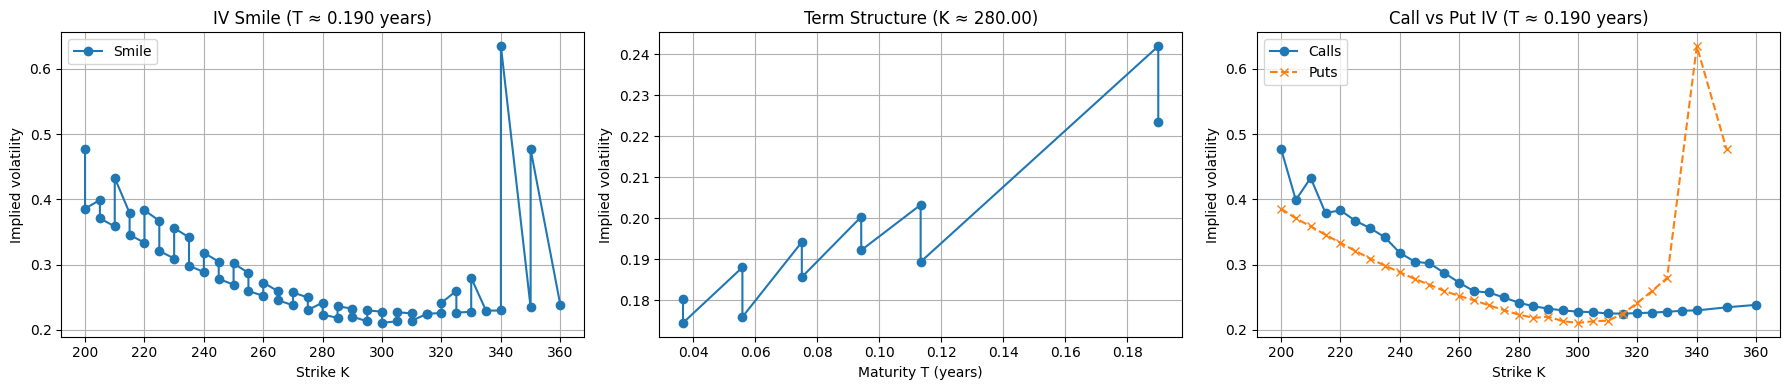

In [166]:
# ===============================
# Output 2 – SMILE & TERM STRUCTURE
# ===============================

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Reference maturity (in years) used to select the closest available maturity for the smile
target_maturity_for_smile = 0.25   # ~3 months (nearest tradable maturity will be used)

# Reference strike used to inspect the term structure (typically around-the-money)
target_strike_for_term = S0        # ATM reference level


# 1) IV Smile
plot_iv_smile(
    iv_df=iv_df,
    maturity=target_maturity_for_smile,
    ax=axes[0],
    label="Smile",
)

# 2) Term structure at chosen strike
plot_term_structure(
    iv_df=iv_df,
    strike=target_strike_for_term,
    ax=axes[1],
)

# 3) Call vs Put IV comparison (same maturity as smile)
plot_call_put_iv_comparison(
    iv_df=iv_df,
    maturity=target_maturity_for_smile,
    ax=axes[2],
)

plt.tight_layout()
plt.show()

## Output 3 - IV Surface & Distribution

*Here we move from one-dimensional slices to the full implied volatility surface by interpolating market IVs on a regular (strike, maturity) grid to obtain IV(K, T).
We then visualize the result through a 3D surface, a 2D heatmap, and an IV distribution histogram to reveal global structure, regimes, and potential outliers.*


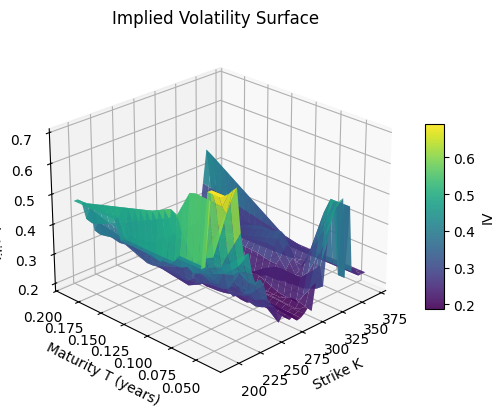

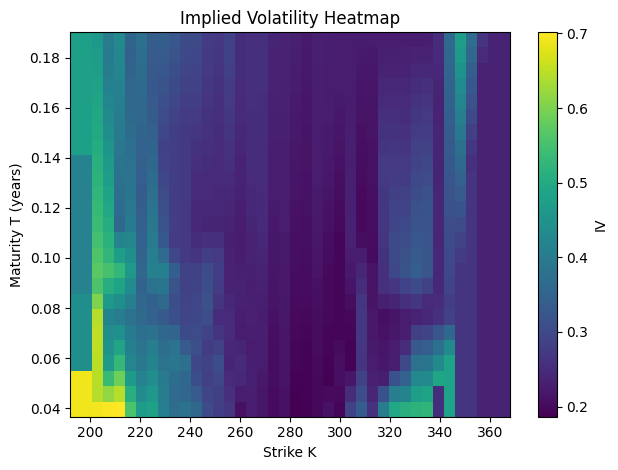

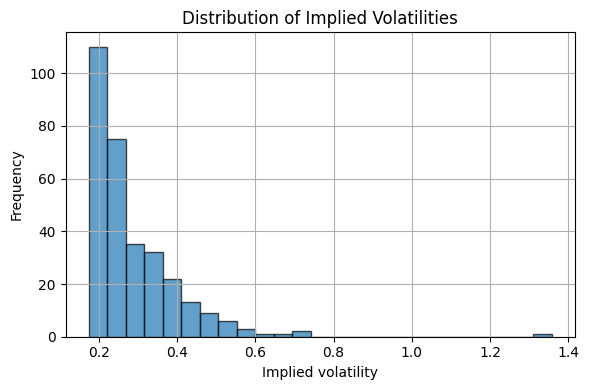

In [167]:
# ===============================
# Output 3 – IV SURFACE & Distribution
# ===============================

nK = iv_df["K"].nunique()
nT = iv_df["T"].nunique()

if nK < 3 or nT < 3:
    print(
        f"[INFO] Not enough distinct strikes/maturities to build a 2D surface "
        f"(unique K = {nK}, unique T = {nT}). Skipping surface plots."
    )
else:
    K_grid, T_grid, IV_surface = build_iv_surface_api(
        iv_df=iv_df,
        grid_params=grid_params,
    )

    plot_iv_surface_3d(
        K_grid=K_grid,
        T_grid=T_grid,
        IV_surface=IV_surface,
        elev=25,
        azim=-135,
    )
    plt.show()

    plot_iv_heatmap(
        K_grid=K_grid,
        T_grid=T_grid,
        IV_surface=IV_surface,
    )
    plt.tight_layout()
    plt.show()

# Histogram – always fine
fig, ax = plt.subplots(figsize=(6, 4))
plot_iv_histogram(iv_df=iv_df, ax=ax, bins=25)
plt.tight_layout()
plt.show()

## Output 4 - VIX-like Index

*This output reports an internal VIX-like volatility index computed at a target maturity of approximately 0.082 years, based on near-the-money implied volatilities. The reported value represents the market’s implied annualized volatility level for the underlying at the observation date.*


In [168]:
# ===============================
# Output 4 – VIX-LIKE INDEX
# ===============================

vix_level = compute_vix_like_api(
    iv_df=iv_df,
    S0=S0,
    r=r,
    T_target=vix_params["T_target"],
    K_grid=K_grid,
    T_grid=T_grid,
    IV_surface=IV_surface,
    use_surface=vix_params["use_surface"],
    simple_params=vix_params.get("simple_params", None),
)

if vix_level is None:
    print(">>> VIX-like index could not be computed (insufficient data).")
else:
    print(">>> VIX-like internal volatility index")
    print(f"Target maturity ~ {vix_params['T_target']:.3f} years")
    print(f"VIX-like level : {vix_level:.2f}% annualized")

>>> VIX-like internal volatility index
Target maturity ~ 0.082 years
VIX-like level : 19.11% annualized
